# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_cores-oracle.run1",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'CORES_4', 'CORES_2', 'CORES_3', 'CORES_1', 'CORES_5'}


{'ORACLE.run1_44', 'ORACLE.run1_8', 'ORACLE.run1_32', 'ORACLE.run1_38', 'ORACLE.run1_50', 'ORACLE.run1_26', 'ORACLE.run1_20', 'ORACLE.run1_14'}


tensor([[[-0.0089, -0.0132,  0.0126,  ..., -0.0215, -0.0297,  0.0087],
         [ 0.0047, -0.0256, -0.0276,  ..., -0.0239, -0.0096, -0.0198]],

        [[ 0.0166,  0.0381, -0.0073,  ...,  0.0097,  0.0181,  0.0042],
         [-0.0159, -0.0008,  0.0349,  ..., -0.0364, -0.0047,  0.0251]],

        [[-0.0216, -0.0086,  0.0370,  ..., -0.0336, -0.0061,  0.0243],
         [-0.0124, -0.0331, -0.0005,  ...,  0.0037, -0.0158, -0.0068]],

        ...,

        [[ 0.0166,  0.0204,  0.0110,  ..., -0.0348, -0.0398, -0.0109],
         [ 0.0118,  0.0114, -0.0122,  ..., -0.0232,  0.0066,  0.0143]],

        [[ 0.0084,  0.0084, -0.0037,  ..., -0.0018, -0.0091, -0.0008],
         [ 0.0032,  0.0011, -0.0067,  ..., -0.0024,  0.0017, -0.0132]],

        [[-0.0032,  0.0027,  0.0059,  ...,  0.0092,  0.0088, -0.0088],
         [ 0.0070,  0.0082,  0.0080,  ...,  0.0125,  0.0016, -0.0012]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 735], examples_per_second: 335.6104, train_label_loss: 1.8477, 


epoch: 1, [batch: 74 / 735], examples_per_second: 3139.5356, train_label_loss: 0.2139, 


epoch: 1, [batch: 147 / 735], examples_per_second: 3170.3060, train_label_loss: 0.4924, 


epoch: 1, [batch: 221 / 735], examples_per_second: 3147.5317, train_label_loss: 0.1504, 


epoch: 1, [batch: 294 / 735], examples_per_second: 3167.2442, train_label_loss: 0.0364, 


epoch: 1, [batch: 368 / 735], examples_per_second: 3169.6276, train_label_loss: 0.1841, 


epoch: 1, [batch: 441 / 735], examples_per_second: 3171.1380, train_label_loss: 0.0042, 


epoch: 1, [batch: 514 / 735], examples_per_second: 3181.1750, train_label_loss: 0.0163, 


epoch: 1, [batch: 588 / 735], examples_per_second: 3184.2412, train_label_loss: 0.0198, 


epoch: 1, [batch: 661 / 735], examples_per_second: 3214.3196, train_label_loss: 0.0003, 


epoch: 1, source_val_acc_label: 0.9788, target_val_acc_label: 0.4267, source_val_label_loss: 0.0695, target_val_label_loss: 2.0011, 


New best


epoch: 2, [batch: 1 / 734], examples_per_second: 4.4423, train_label_loss: 0.0598, 


epoch: 2, [batch: 74 / 734], examples_per_second: 3200.5953, train_label_loss: 0.1399, 


epoch: 2, [batch: 147 / 734], examples_per_second: 3192.4074, train_label_loss: 0.0210, 


epoch: 2, [batch: 220 / 734], examples_per_second: 3202.3473, train_label_loss: 0.1357, 


epoch: 2, [batch: 294 / 734], examples_per_second: 3196.5706, train_label_loss: 0.0000, 


epoch: 2, [batch: 367 / 734], examples_per_second: 3191.7564, train_label_loss: 0.1347, 


epoch: 2, [batch: 440 / 734], examples_per_second: 3215.6214, train_label_loss: 0.0038, 


epoch: 2, [batch: 514 / 734], examples_per_second: 3164.4434, train_label_loss: 0.1263, 


epoch: 2, [batch: 587 / 734], examples_per_second: 3183.1866, train_label_loss: 0.0146, 


epoch: 2, [batch: 660 / 734], examples_per_second: 3196.6052, train_label_loss: 0.0088, 


epoch: 2, source_val_acc_label: 0.9903, target_val_acc_label: 0.4048, source_val_label_loss: 0.0309, target_val_label_loss: 1.8823, 


New best


epoch: 3, [batch: 1 / 734], examples_per_second: 4.4181, train_label_loss: 0.0007, 


epoch: 3, [batch: 74 / 734], examples_per_second: 3151.5488, train_label_loss: 0.0012, 


epoch: 3, [batch: 147 / 734], examples_per_second: 3157.5138, train_label_loss: 0.0564, 


epoch: 3, [batch: 220 / 734], examples_per_second: 3169.7522, train_label_loss: 0.0791, 


epoch: 3, [batch: 294 / 734], examples_per_second: 3174.9775, train_label_loss: 0.0191, 


epoch: 3, [batch: 367 / 734], examples_per_second: 3171.6681, train_label_loss: 0.0134, 


epoch: 3, [batch: 440 / 734], examples_per_second: 3177.5484, train_label_loss: 0.0008, 


epoch: 3, [batch: 514 / 734], examples_per_second: 3166.0711, train_label_loss: 0.0115, 


epoch: 3, [batch: 587 / 734], examples_per_second: 3149.5117, train_label_loss: 0.0033, 


epoch: 3, [batch: 660 / 734], examples_per_second: 3156.5067, train_label_loss: 0.0044, 


epoch: 3, source_val_acc_label: 0.9928, target_val_acc_label: 0.3872, source_val_label_loss: 0.0257, target_val_label_loss: 1.7827, 


New best


epoch: 4, [batch: 1 / 734], examples_per_second: 4.4037, train_label_loss: 0.0000, 


epoch: 4, [batch: 74 / 734], examples_per_second: 3150.8531, train_label_loss: 0.0127, 


epoch: 4, [batch: 147 / 734], examples_per_second: 3203.7035, train_label_loss: 0.0009, 


epoch: 4, [batch: 220 / 734], examples_per_second: 3178.3466, train_label_loss: 0.0475, 


epoch: 4, [batch: 294 / 734], examples_per_second: 3163.6080, train_label_loss: 0.0529, 


epoch: 4, [batch: 367 / 734], examples_per_second: 3207.9542, train_label_loss: 0.0035, 


epoch: 4, [batch: 440 / 734], examples_per_second: 3187.2859, train_label_loss: 0.0001, 


epoch: 4, [batch: 514 / 734], examples_per_second: 3159.2720, train_label_loss: 0.0000, 


epoch: 4, [batch: 587 / 734], examples_per_second: 3171.7132, train_label_loss: 0.0028, 


epoch: 4, [batch: 660 / 734], examples_per_second: 3191.3455, train_label_loss: 0.0197, 


epoch: 4, source_val_acc_label: 0.9978, target_val_acc_label: 0.3540, source_val_label_loss: 0.0098, target_val_label_loss: 1.9248, 


epoch: 5, [batch: 1 / 737], examples_per_second: 4.4012, train_label_loss: 0.0000, 


epoch: 5, [batch: 74 / 737], examples_per_second: 3145.4831, train_label_loss: 0.0014, 


epoch: 5, [batch: 148 / 737], examples_per_second: 3168.0678, train_label_loss: 0.0011, 


epoch: 5, [batch: 221 / 737], examples_per_second: 3174.9964, train_label_loss: 0.0004, 


epoch: 5, [batch: 295 / 737], examples_per_second: 3167.6022, train_label_loss: 0.0066, 


epoch: 5, [batch: 369 / 737], examples_per_second: 3168.2113, train_label_loss: 0.0001, 


epoch: 5, [batch: 442 / 737], examples_per_second: 3167.4609, train_label_loss: 0.0000, 


epoch: 5, [batch: 516 / 737], examples_per_second: 3176.1390, train_label_loss: 0.0030, 


epoch: 5, [batch: 589 / 737], examples_per_second: 3185.7488, train_label_loss: 0.1690, 


epoch: 5, [batch: 663 / 737], examples_per_second: 3175.2617, train_label_loss: 0.0097, 


epoch: 5, source_val_acc_label: 0.9959, target_val_acc_label: 0.3369, source_val_label_loss: 0.0147, target_val_label_loss: 1.9214, 


epoch: 6, [batch: 1 / 733], examples_per_second: 4.4025, train_label_loss: 0.0000, 


epoch: 6, [batch: 74 / 733], examples_per_second: 3134.5562, train_label_loss: 0.0003, 


epoch: 6, [batch: 147 / 733], examples_per_second: 3159.5486, train_label_loss: 0.0006, 


epoch: 6, [batch: 220 / 733], examples_per_second: 3168.5512, train_label_loss: 0.0000, 


epoch: 6, [batch: 293 / 733], examples_per_second: 3157.6294, train_label_loss: 0.0038, 


epoch: 6, [batch: 367 / 733], examples_per_second: 3201.5297, train_label_loss: 0.0000, 


epoch: 6, [batch: 440 / 733], examples_per_second: 3229.3018, train_label_loss: 0.0018, 


epoch: 6, [batch: 513 / 733], examples_per_second: 3184.1917, train_label_loss: 0.0000, 


epoch: 6, [batch: 586 / 733], examples_per_second: 3190.8201, train_label_loss: 0.0210, 


epoch: 6, [batch: 659 / 733], examples_per_second: 3172.3754, train_label_loss: 0.0741, 


epoch: 6, source_val_acc_label: 0.9956, target_val_acc_label: 0.3884, source_val_label_loss: 0.0161, target_val_label_loss: 1.6653, 


New best


epoch: 7, [batch: 1 / 732], examples_per_second: 4.4129, train_label_loss: 0.0000, 


epoch: 7, [batch: 74 / 732], examples_per_second: 3161.1237, train_label_loss: 0.0014, 


epoch: 7, [batch: 147 / 732], examples_per_second: 3184.5899, train_label_loss: 0.0080, 


epoch: 7, [batch: 220 / 732], examples_per_second: 3130.2632, train_label_loss: 0.0000, 


epoch: 7, [batch: 293 / 732], examples_per_second: 3173.5817, train_label_loss: 0.0001, 


epoch: 7, [batch: 366 / 732], examples_per_second: 3177.5537, train_label_loss: 0.0011, 


epoch: 7, [batch: 439 / 732], examples_per_second: 3164.5481, train_label_loss: 0.0983, 


epoch: 7, [batch: 512 / 732], examples_per_second: 3167.1083, train_label_loss: 0.0000, 


epoch: 7, [batch: 585 / 732], examples_per_second: 3182.1205, train_label_loss: 0.0002, 


epoch: 7, [batch: 658 / 732], examples_per_second: 3172.7029, train_label_loss: 0.0023, 


epoch: 7, source_val_acc_label: 0.9944, target_val_acc_label: 0.3544, source_val_label_loss: 0.0244, target_val_label_loss: 1.7782, 


epoch: 8, [batch: 1 / 737], examples_per_second: 4.4154, train_label_loss: 0.0001, 


epoch: 8, [batch: 74 / 737], examples_per_second: 3150.2173, train_label_loss: 0.0005, 


epoch: 8, [batch: 148 / 737], examples_per_second: 3155.5097, train_label_loss: 0.0000, 


epoch: 8, [batch: 221 / 737], examples_per_second: 3170.5317, train_label_loss: 0.0000, 


epoch: 8, [batch: 295 / 737], examples_per_second: 3144.3980, train_label_loss: 0.0000, 


epoch: 8, [batch: 369 / 737], examples_per_second: 3167.8391, train_label_loss: 0.1016, 


epoch: 8, [batch: 442 / 737], examples_per_second: 3154.6575, train_label_loss: 0.1100, 


epoch: 8, [batch: 516 / 737], examples_per_second: 3144.6027, train_label_loss: 0.0002, 


epoch: 8, [batch: 589 / 737], examples_per_second: 3171.9843, train_label_loss: 0.0001, 


epoch: 8, [batch: 663 / 737], examples_per_second: 3171.9850, train_label_loss: 0.0000, 


epoch: 8, source_val_acc_label: 0.9947, target_val_acc_label: 0.3496, source_val_label_loss: 0.0115, target_val_label_loss: 1.8281, 


epoch: 9, [batch: 1 / 731], examples_per_second: 4.4151, train_label_loss: 0.0000, 


epoch: 9, [batch: 74 / 731], examples_per_second: 3133.8612, train_label_loss: 0.0004, 


epoch: 9, [batch: 147 / 731], examples_per_second: 3210.3364, train_label_loss: 0.0000, 


epoch: 9, [batch: 220 / 731], examples_per_second: 3217.0856, train_label_loss: 0.0000, 


epoch: 9, [batch: 293 / 731], examples_per_second: 3195.1741, train_label_loss: 0.0002, 


epoch: 9, [batch: 366 / 731], examples_per_second: 3178.5268, train_label_loss: 0.0001, 


epoch: 9, [batch: 439 / 731], examples_per_second: 3160.3260, train_label_loss: 0.0107, 


epoch: 9, [batch: 512 / 731], examples_per_second: 3197.8956, train_label_loss: 0.0000, 


epoch: 9, [batch: 585 / 731], examples_per_second: 3180.4315, train_label_loss: 0.0000, 


epoch: 9, [batch: 658 / 731], examples_per_second: 3184.0688, train_label_loss: 0.0000, 


epoch: 9, source_val_acc_label: 0.9953, target_val_acc_label: 0.3392, source_val_label_loss: 0.0225, target_val_label_loss: 1.7976, 


epoch: 10, [batch: 1 / 734], examples_per_second: 4.3827, train_label_loss: 0.0004, 


epoch: 10, [batch: 74 / 734], examples_per_second: 3134.3171, train_label_loss: 0.0007, 


epoch: 10, [batch: 147 / 734], examples_per_second: 3175.3438, train_label_loss: 0.0002, 


epoch: 10, [batch: 220 / 734], examples_per_second: 3166.9781, train_label_loss: 0.0132, 


epoch: 10, [batch: 294 / 734], examples_per_second: 3162.8488, train_label_loss: 0.0000, 


epoch: 10, [batch: 367 / 734], examples_per_second: 3152.9629, train_label_loss: 0.0001, 


epoch: 10, [batch: 440 / 734], examples_per_second: 3156.5173, train_label_loss: 0.1223, 


epoch: 10, [batch: 514 / 734], examples_per_second: 3144.0460, train_label_loss: 0.0000, 


epoch: 10, [batch: 587 / 734], examples_per_second: 3210.1723, train_label_loss: 0.0000, 


epoch: 10, [batch: 660 / 734], examples_per_second: 3222.2042, train_label_loss: 0.0000, 


epoch: 10, source_val_acc_label: 0.9962, target_val_acc_label: 0.3611, source_val_label_loss: 0.0124, target_val_label_loss: 1.7670, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

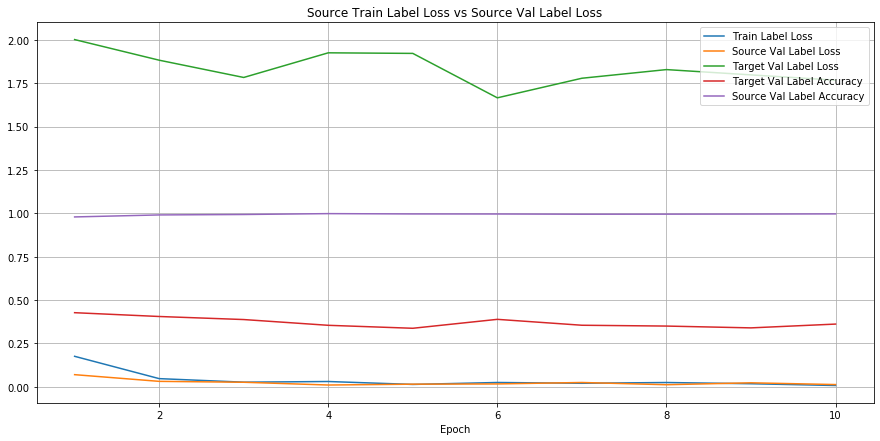

In [25]:
ax = get_loss_curve(experiment)
plt.show()

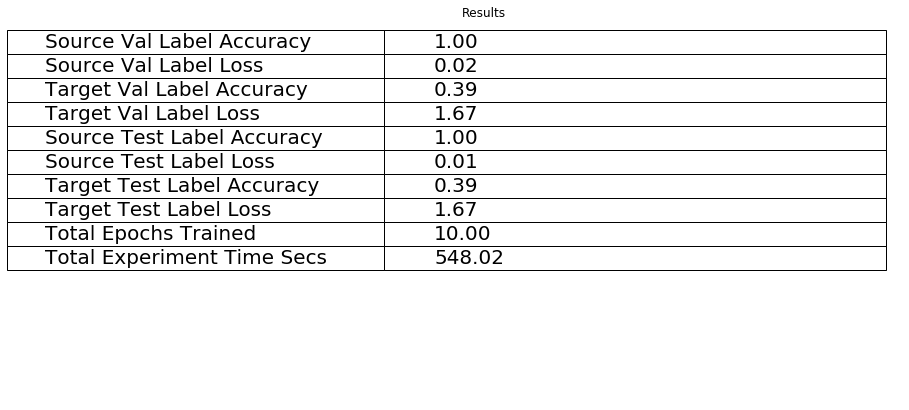

In [26]:
get_results_table(experiment)

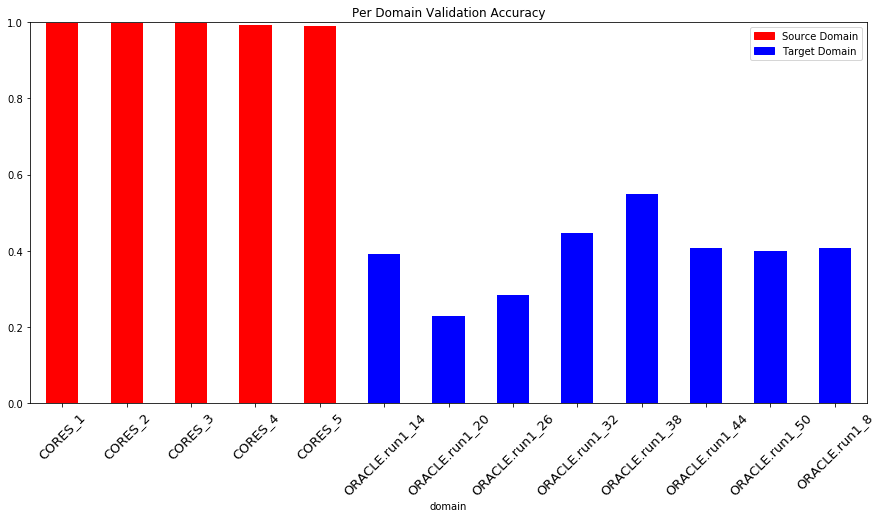

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.996875 Target Test Label Accuracy: 0.38608723958333335
Source Val Label Accuracy: 0.995625 Target Val Label Accuracy: 0.38837890625


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_cores-oracle.run1", "parameters": {"experiment_name": "tl_1_cores-oracle.run1", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_featu